# Stable Diffusion Autoencoder

In [67]:
from diffusers import AutoencoderKL

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

torch_device = "cpu"
vae.to(torch_device)


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [68]:
import h5py
import numpy as np

def get_path(model_sim, ws):
    if model_sim == "p21c":
        dp = f"/users/jsolt/data/jsolt/21cmFAST_sims/p21c14/p21c14_subdiv_sliced_ws{ws}.hdf5"
    elif model_sim == "zreion":
        dp = f"/users/jsolt/data/jsolt/zreion_sims/zreion24/zreion24_subdiv_sliced_ws{ws}.hdf5"
    elif model_sim == "ctrpx":
        dp = f"/users/jsolt/data/jsolt/centralpix_sims/centralpix05/centralpix05_subdiv_sliced_ws{ws}.hdf5"
    return dp

sim="ctrpx"
ws = 3.0
fname = get_path(sim, ws)
n = 0
zs = np.linspace(0,29,6, dtype=int)
color_inputs = []
with h5py.File(fname, "r") as f: 
    for z in zs:
        input = f['lightcones/brightness_temp'][n, z].reshape((1,1,256,256))
        color_inputs.append(np.tile(input, (1,3,1,1)))



In [69]:
import torch
encodings = []
for color_input in color_inputs:
    encodings.append(vae.encode(torch.from_numpy(color_input)))

In [70]:
color_outputs = []
for encoding in encodings:
    color_outputs.append(vae.decode(encoding.latent_dist.mean).sample.detach().numpy())

In [ ]:
%matplotlib inline

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/users/jsolt/FourierNN')
from plotting import plot_image_rows


rowdict = {
    "input":[],
    "output":[],
    "difference":[],
    }

simdict = {
    "p21c":"21cmFAST",
    "zreion":"RLS",
    "ctrpx":"21cmFAST (central-pixel)"
}

for i in range(len(color_inputs)):
    color_input, color_output = color_inputs[i], color_outputs[i]
    diff = color_input - color_output
    label_dict = {
        "input": color_input,
        "output": color_output,
        "difference": diff
    }
    for label, img in label_dict.items():
        image = np.mean(image, axis=(0,1))
        rowdict[label].append(image)

for label in rowdict.keys():
    rowdict[label] = np.array(rowdict[label])
    

print(rowdict["input"].shape)
plot_image_rows(rowdict, title=f"{simdict[sim]} wedge slope {ws}", fname=f"{sim}_ws{ws}.png")

(6, 256, 256)


# Visualize Latent Space

In [1]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

torch_device = "cpu"
vae.to(torch_device);

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [18]:
import h5py
import numpy as np

def get_path(model_sim, ws):
    if model_sim == "p21c":
        dp = f"/users/jsolt/data/jsolt/21cmFAST_sims/p21c14/p21c14_subdiv_sliced_ws{ws}.hdf5"
    elif model_sim == "zreion":
        dp = f"/users/jsolt/data/jsolt/zreion_sims/zreion24/zreion24_subdiv_sliced_ws{ws}.hdf5"
    elif model_sim == "ctrpx":
        dp = f"/users/jsolt/data/jsolt/centralpix_sims/centralpix05/centralpix05_subdiv_sliced_ws{ws}.hdf5"
    return dp

sim="ctrpx"
ws = 3.0
fname = get_path(sim, ws)
n = 1
zs = np.linspace(0,29,6, dtype=int)
color_inputs = []
with h5py.File(fname, "r") as f: 
    for z in zs:
        input = f['lightcones/brightness_temp'][n, z].reshape((1,1,256,256))
        color_inputs.append(np.tile(input, (1,3,1,1)))



In [19]:
import torch
encodings = []
for color_input in color_inputs:
    encodings.append(vae.encode(torch.from_numpy(color_input)))
    

In [20]:
print(encodings[0].latent_dist.__dict__.keys())


dict_keys(['parameters', 'mean', 'logvar', 'deterministic', 'std', 'var'])


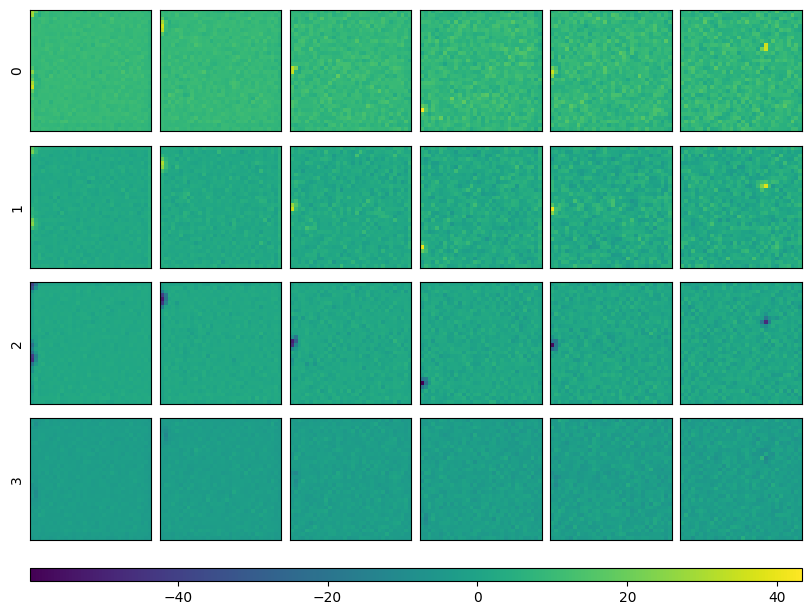

In [21]:
%matplotlib inline

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/users/jsolt/FourierNN')
from plotting import plot_image_rows


rowdict = {f"{j}":[] for j in range(4)}


simdict = {
    "p21c":"21cmFAST",
    "zreion":"RLS",
    "ctrpx":"21cmFAST (central-pixel)"
}

clean_encodings = [encodings[i].latent_dist.mean.detach().numpy() for i in range(len(encodings))]

for i in range(len(clean_encodings)):
    encoding = clean_encodings[i]
    label_dict = {f"{j}":encoding[0,j] for j in range(4)}
    for label, img in label_dict.items():
        rowdict[label].append(img)

for label in rowdict.keys():
    rowdict[label] = np.array(rowdict[label])
    

plot_image_rows(rowdict)

(6, 256, 256)


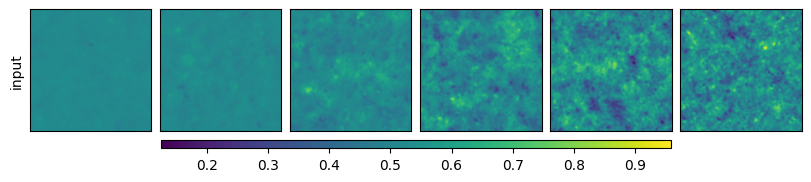

In [22]:
%matplotlib inline

rowdict = {
    "input":[],
    }

simdict = {
    "p21c":"21cmFAST",
    "zreion":"RLS",
    "ctrpx":"21cmFAST (central-pixel)"
}

for i in range(len(color_inputs)):
    color_input = color_inputs[i]
    label_dict = {
        "input": color_input,
    }
    for label, image in label_dict.items():
        image = np.mean(image, axis=(0,1))
        rowdict[label].append(image)

for label in rowdict.keys():
    rowdict[label] = np.array(rowdict[label])
    

print(rowdict["input"].shape)
plot_image_rows(rowdict)